## Value-at-Risk: Using Filtered Historical Simulation

**Functions**

`arch_model`, `ARCHModelResult.std_resid`, `np.percentile`

### Exercise 82
Use a GARCH(1,1) model to construct filtered historical VaR for the S&P 500 and
the EUR/USD exchange rate, using 10 years of data.

**Note**: For simplicity, estimate the model on the full sample, but start the
historical simulation at 25% of the data, and then build the additional forecasts
using a recursive scheme.

Let's begin by loading the packages and importing the data:

In [1]:
from arch import arch_model
import pandas as pd
import numpy as np

In [2]:
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

Creating returns:

In [3]:
sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

Since the question has told us that, for simplicity, we can estimate the model on the full sample, we can start by estimating the GARCH(1,1) model we will use to construct the filtered historical VaR. We can start with the returns of the SP500:

In [4]:
# Setting the model (default is GARCH(1,1))
mod_sp = arch_model(sp500_returns)
# Fitting the model
res_sp = mod_sp.fit(disp="off")

We can now use this estimated model to forecast the one step ahead variance accoring to this GARCH(1,1)

In [5]:
# Forecasting variance
forecasts_sp = res_sp.forecast(start=sp500_returns.index[0])

After estimating the one step ahead variance, we can use it to construct the filtered historical simulation.
In order to construct this, we need:
- One step ahead variance forecast
- Quantile estimate for standarized residual

We already calculated the one step ahead forecasts. Now let's get the series of standardized residuals calculate the VaR using `expanding` and `quantile`.

In [6]:
# Standardized residuals from our model
std_resid_sp = res_sp.std_resid

Now with both the **forecasts** and the **std_resid** we can calculate the VaR. But remember, we are asked to start the historical simulation at 25% of the data. So we need to find what is this starting point for our analysis.

In [7]:
# Finding the starting point 
start = int(0.25 * std_resid_sp.shape[0])

We can then use the same structure from last class to calculate the 0.05 quantile of the **std_resid** series.

In [8]:
# Calculating quantile
std_quantile_sp = std_resid_sp.expanding(min_periods=start).quantile(0.05)

Finally, we can use the **std_quantile** and our time-varying one step ahead conditional variance forecasts to perform the VaR forecasts. 

In [9]:
# Getting the mean return from our model
mu = res_sp.params.mu
# One step ahead conditional volatility forecasts (square root of conditional variance forecast)
sigma = np.sqrt(forecasts_sp.variance["h.1"])
# Using these to calculate the VaR
var_sp = -(mu+sigma*std_quantile_sp)
# Dropping na
var_sp = var_sp.dropna()

Let's plot the estimated VaR. 

In [10]:
# Importing the plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Setting the plot properties
sns.set_style("darkgrid")
plt.rc("figure",figsize=(16,6))
plt.rc("font",size=14)

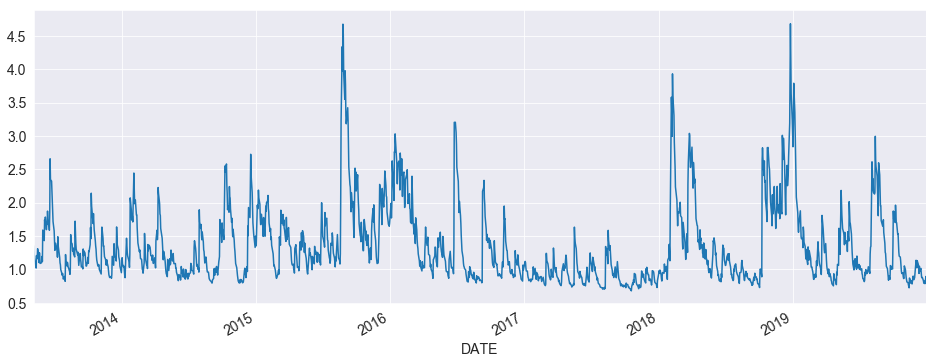

In [12]:
# Plotting the VaR
fig, ax = plt.subplots(1,1)
var_sp.plot(ax=ax)
xl = ax.set_xlim(var_sp.index.min(), var_sp.index.max())

We can now perform the same analysis to Euro/Dollar exchange rate. 

#### Explanation

Multi-step VaR is harder.  We need to simulate returns for $h$ days and then take
the quantile of the simulated returns. While `arch` can do this for us, it is
instructive to manually implement the steps. We start with a single day,
and then wrap that in a loop to compute the 5-day VaR for the entire sample.

In [13]:
# Setting the model (default is GARCH(1,1))
mod_eur = arch_model(eurusd_returns)
# Fitting the model
res_eur = mod_eur.fit(disp="off")
# Forecasting variance
forecasts_eur = res_eur.forecast(start=sp500_returns.index[0])# Standardized residuals from our model
# Standardized residuals from our model
std_resid_eur = res_eur.std_resid

In [14]:
# Finding the starting point 
start = int(0.25 * std_resid_eur.shape[0])
# Calculating quantile
std_quantile_eur = std_resid_eur.expanding(min_periods=start).quantile(0.05)
# Getting the mean return from our model
mu = res_eur.params.mu
# One step ahead conditional volatility forecasts (square root of conditional variance forecast)
sigma = np.sqrt(forecasts_eur.variance["h.1"])
# Using these to calculate the VaR
var_eur = -(mu+sigma*std_quantile_eur)
# Dropping na
var_eur = var_eur.dropna()

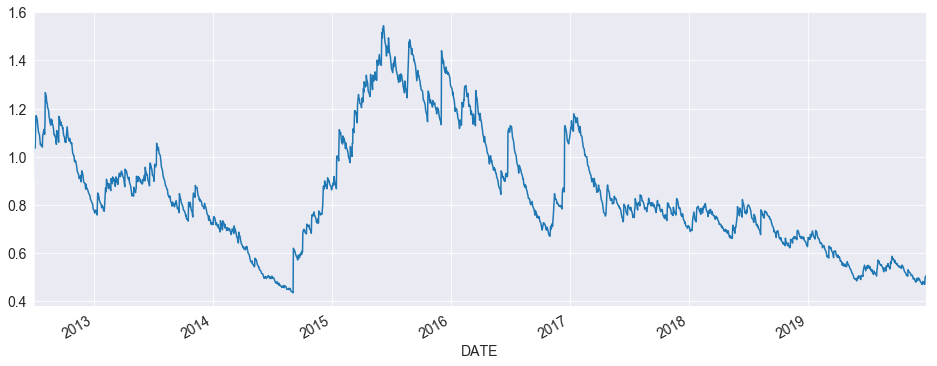

In [15]:
# Plotting the VaR
fig, ax = plt.subplots(1,1)
var_eur.plot(ax=ax)
xl = ax.set_xlim(var_eur.index.min(), var_eur.index.max())

To conclude, let's save the data to use it in the 

In [16]:
with pd.HDFStore("./data/fhs-var.h5", mode="w") as hdf:
    hdf.put("sp500_var", var_sp)
    hdf.put("eurusd_var", var_eur)